In [2]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# # LightAutoML presets, task and report generation
# from lightautoml.automl.presets.tabular_presets import TabularAutoML
# from lightautoml.tasks import Task

In [5]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 1500 # equal to 25 minutes
TARGET_NAME = 'final_price'

In [6]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [1]:
INPUT_DIR = './'

In [3]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv')
print(train_data.shape)
train_data.head(3)

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0


In [42]:
train_data['model_rating'] = 0
train_data['vehicle_model'] =  train_data['vehicle_model'].apply(lambda x: ''.join(str(x).split(' ')))
train_data['vehicle_gearbox_type'] =  train_data['vehicle_gearbox_type'].apply(lambda x: ''.join(str(x).split(' ')))

In [43]:
def set_gearbox_ratings(df):
    
    # Create empty dictionaries
    models = df['vehicle_model'].value_counts()
    model_rating = dict(models)
    #print(model_rating)
    # Go along the rows by indexes
    for row in df.index:
        
        model = str(df['vehicle_model'].iloc[row])
        gearbox = str(df['vehicle_gearbox_type'].iloc[row])
        
        if gearbox in ['Automatic', 'Tiptronic', 'Variator']:
            gear_type = 0.7
        elif gearbox == 'Manual':
            gear_type = 0.3
        

        if model in model_rating.keys():
            df['model_rating'].iloc[row] = round(model_rating[model] * gear_type)
        if row < 10:
            print(model,gearbox, gear_type, df['model_rating'].iloc[row])
            
    return

In [44]:
set_gearbox_ratings(train_data)

Aquas Automatic 0.7 3
C220 Manual 0.3 13
Veloster Tiptronic 0.7 120
SantaFE Automatic 0.7 634
CHR Automatic 0.7 75
Delica Automatic 0.7 22
Tucson Automatic 0.7 884
X5 Tiptronic 0.7 351
Aqua Automatic 0.7 299
640 Tiptronic 0.7 2


/home/freeradical/anaconda3/envs/sf/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [45]:
train_data.head()

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,model_rating
0,0,TOYOTA,Aquas,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0,3
1,1,MERCEDES-BENZ,C220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0,13
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0,120
3,3,HYUNDAI,SantaFE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0,634
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0,75


In [46]:
def category_transform(category):
    category_dict = {
    'Sedan': 11,
    'Jeep': 10,
    'Hatchback': 9,
    'Minivan': 8,
    'Coupe': 7,
    'Universal': 6,
    'Microbus': 5,
    'Goodswagon': 4,
    'Pickup': 3,
    'Cabriolet': 2,
    'Limousine': 1,
    'nan': 0
    }
    return category_dict[category]
train_data['vehicle_category'] =  train_data['vehicle_category'].apply(lambda x: ''.join(str(x).split(' ')))
train_data['vehicle_category'] = train_data['vehicle_category'].apply(category_transform)

In [47]:
train_data['vehicle_gearbox_type'].value_counts()


Automatic    24290
Tiptronic     5557
Manual        3736
Variator      1416
nan              1
Name: vehicle_gearbox_type, dtype: int64

In [48]:
train_data[train_data['vehicle_model'] == 'C 220']

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,model_rating


In [49]:
train_data.head()

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,model_rating
0,0,TOYOTA,Aquas,11,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0,3
1,1,MERCEDES-BENZ,C220,11,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0,13
2,2,HYUNDAI,Veloster,9,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0,120
3,3,HYUNDAI,SantaFE,10,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0,634
4,4,TOYOTA,CHR,10,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0,75


In [36]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           35000 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    35000 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [87]:
year_mask = (train_data['vehicle_year'] > 1950)
data = train_data[year_mask]
data['car_age'] = 2022 - data['vehicle_year']

/tmp/ipykernel_43218/1681423119.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['car_age'] = 2022 - data['vehicle_year']


In [79]:
mileage_mask = (train_data['current_mileage'] < 5e5)
data = train_data[mileage_mask]

In [105]:
price_mask1 = (train_data['final_price'] < 100)
price_mask2 = (train_data['final_price'] > 0 ) 
data = train_data[price_mask1 & price_mask2]

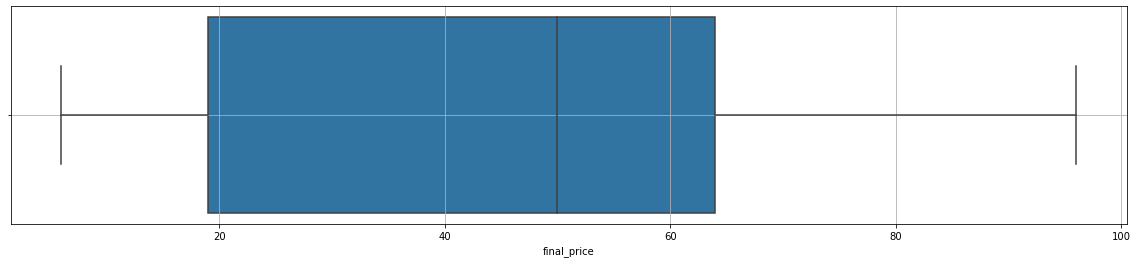

In [104]:
fig, axes = plt.subplots(nrows=1, figsize=(20, 4))
boxplot1 = sns.boxplot(
    data=data,
    x='final_price',
    orient='h',
    ax=axes,
    width=0.9
);
# boxplot1.set_title('Distribution of customer balances');
# boxplot1.set_xlabel('Balances');
# boxplot1.set_xticks([x*15000 for x in range(1, 18)]);
# boxplot1.xaxis.set_tick_params(rotation=60);
# boxplot1.set_ylabel('Loyality');



boxplot1.grid()

In [ ]:
%%time

#import category_encoders as ce

def create_expert_feats(data):
    year_mask = (data['vehicle_year'] > 1992)
    data = data[year_mask]
    data['car_age'] = 0
    data['car_age'] = 2022 - data['vehicle_year']
    
    mileage_mask = (data['current_mileage'] < 5e5)
    data = data[mileage_mask]
    
    price_mask = (train_data['final_price'] < 1e3)
    data = train_data[price_mask]
    
    
    data['car_vin'] =  data['car_vin'].apply(lambda x: ''.join(str(x).split(' '))[:11])
    
#     data['vehicle_manufacturer'] =  data['vehicle_manufacturer'].apply(lambda x: ''.join(str(x).split(' ')))
  
    data['vehicle_model'] =  data['vehicle_model'].apply(lambda x: ''.join(str(x).split(' ')))
    data['vehicle_gearbox_type'] =  data['vehicle_gearbox_type'].apply(lambda x: ''.join(str(x).split(' ')))
    
    
#     data['vehicle_category'] =  data['vehicle_category'].apply(lambda x: ''.join(str(x).split(' ')))




    # 3 +++
    data['car_novelty_ratio'] = 1e6/(car_age * data['current_mileage'])

    display(data.head(5))
    return data
     
train_data = create_expert_feats(train_data)
test_data = create_expert_feats(test_data)

<AxesSubplot:>

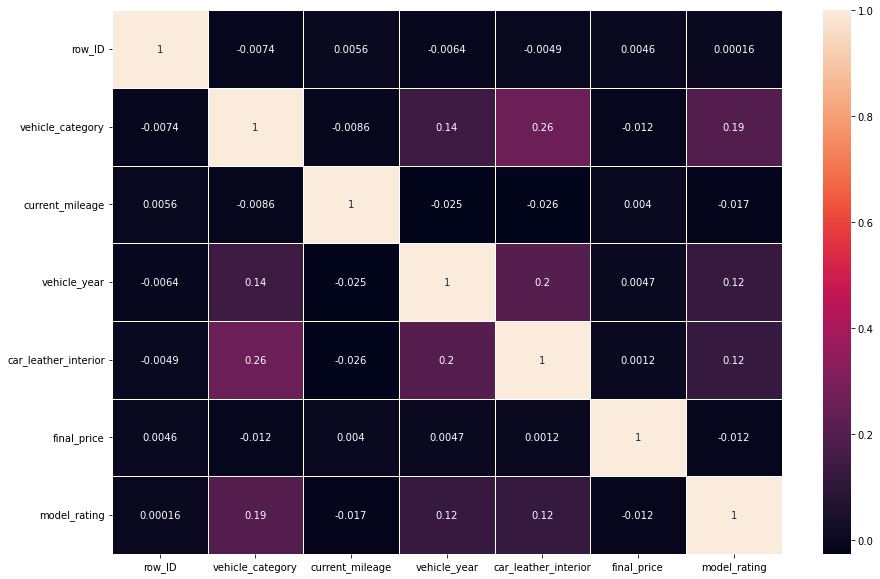

In [52]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(train_data.corr(), annot=True, linewidths=.5, ax=ax)

In [ ]:
train_data = train_data[train_data['vehicle_year'] > 1980]
train_data = train_data[train_data['final_price'] < 90000]
train_data = train_data[train_data['current_mileage'] < 500000]

In [ ]:
def create_expert_feats(data):
    data['age_of_car'] = 2022 - data['vehicle_year']
    data = data.drop(['vehicle_year','doors_cnt','row_ID'], axis=1, inplace=True)
    return data

create_expert_feats(train_data)
create_expert_feats(test_data)

In [13]:
# def append_wmi(wmis, vendor, car_vin):
#     """ This function appends new element in dictionary
#         if not exist

#     Args:
#         wmis (dictionary of the lists of the codes) like {'manufacturer": ['JTG', '1T4', ... 'JTD']} 
#         vendor (text string): name of the vehicle manufacturer
#         car_vin (text string): serial of the numbers and symbols (max 17)
#     """
#     if car_vin in ['nan', 'NaN']:
#         return
#     wmi = car_vin[:3]
  
#     if vendor not in wmis.keys():
#         wmis.update({vendor: list()})
#         wmis[vendor].append(wmi)
    
#     elif wmi not in wmis[vendor]:
#         wmis[vendor].append(wmi)
      
#     return


# def append_vds(vdss, model, car_vin):
#     """ This function appends new element in dictionary
#         if not exist

#     Args:
#         vdcs (dictionary of the lists of the codes) like {'model": ['XC', 'SD', ... 'SC']}
#         model (text string): name of the vehicle model
#         car_vin (text string): serial of the numbers and symbols (max 17)
#     """
#     if car_vin in ['nan', 'NaN'] or not len(model):
#         return
#     vds = car_vin[3:5]
  
#     if model not in vdss.keys():
#         vdss.update({model: list()})
#         vdss[model].append(vds)
     
#     elif vds not in vdss[model]:
#         vdss[model].append(vds)
       
#     return


# def get_vin_parts(df):
#     """ This function collect existing vin-codes into dictionary
#         for future implementations

#     Args:
#         df (pandas.DataFrame): The source data that we use for collecting
#     Returns:
#         wmis_dict (dictionary of the lists of the codes) like {'manufacturer": ['JTG', '1T4', ... 'JTD']} 
#         vdcs_dict (dictionary of the lists of the codes) like {'model": ['XC', 'SD', ... 'SC']}
#     """
#     # Create empty dictionaries
#     wmi_dict = dict()
#     vds_dict = dict()
    
#     # Go along the rows by indexes
#     for row in df.index:
#         car_vin = str(df['car_vin'].iloc[row])

#         if len(car_vin) > 3:
            
#             vendor = str(df['vehicle_manufacturer'].iloc[row])
#             # Get World Manufacturers Identification (wmi)
#             append_wmi(wmi_dict, vendor, car_vin)
            
#             model = str(df['vehicle_model'].iloc[row])
#             # Get Vehicle Description Section (vds)
#             append_vds(vds_dict, model, car_vin)
            
#     return wmi_dict, vds_dict


# def set_vin(wmis, vdss, df):
#     """ This function set vin-codes for empty cells
#         using vendor and model information

#     Args:
#         wmis (dictionary of the lists of the codes) like {'manufacturer": ['JTG', '1T4', ... 'JTD']} 
#         vdcs (dictionary of the lists of the codes) like {'model": ['XC', 'SD', ... 'SC']}
#         df (pandas.DataFrame): The source dataframe

#     Returns:
#         pandas.DataFrame: output dataframe
#     """
#     for row in df.index:
#         car_vin = str(df['car_vin'].iloc[row])
        
#         if car_vin in ['nan', 'NaN']:
#             vendor = str(df['vehicle_manufacturer'].iloc[row])
#             model = str(df['vehicle_model'].iloc[row])
            
#             if vendor in wmis.keys():
#                 car_vin = wmis[vendor][0]
#             else:
#                 car_vin = 'nan'
#             if model in vdss.keys():
#                 car_vin += vdss[model][0]
#         else:
#             car_vin = car_vin[1:6]
#         df['car_vin'].iloc[row] = car_vin
                
#     return df

In [26]:
def append_wmi_vds(vins, vendor, model, body_type,car_vin):
    """ This function appends new element in dictionary
        if not exist

    Args:
        wmis (dictionary of the lists of the codes) like {'manufacturer": ['JTG', '1T4', ... 'JTD']} 
        vendor (text string): name of the vehicle manufacturer
        car_vin (text string): serial of the numbers and symbols (max 17)
    """
    if car_vin in ['nan', 'NaN']:
        return
    vin_part = car_vin[:7]
    vehicle = vendor + ' ' + model + ' ' + body_type
  
    if vehicle not in vins.keys():
        vins.update({vehicle: list()})
        vins[vehicle].append(vin_part)
    
    elif vin_part not in vins[vehicle]:
        vins[vehicle].append(vin_part)
      
    return



def get_vin_parts(df):
    """ This function collect existing vin-codes into dictionary
        for future implementations

    Args:
        df (pandas.DataFrame): The source data that we use for collecting
    Returns:
        wmis_dict (dictionary of the lists of the codes) like {'manufacturer": ['JTG', '1T4', ... 'JTD']} 
        vdcs_dict (dictionary of the lists of the codes) like {'model": ['XC', 'SD', ... 'SC']}
    """
    # Create empty dictionary
    vin_dict = dict()
    
    # Go along the rows by indexes
    for row in df.index:
        car_vin = str(df['car_vin'].iloc[row])

        if len(car_vin) > 3:
            vendor = str(df['vehicle_manufacturer'].iloc[row])
            model = str(df['vehicle_model'].iloc[row])
            body_type = str(df['vehicle_category'].iloc[row])
            
            # Get World Manufacturers Identification (wmi) + Vehicle Description Section (vds)
            append_wmi_vds(vin_dict, vendor, model, body_type, car_vin)
            
    return vin_dict


def set_vin_parts(vins, df):
    """ This function set vin-codes for empty cells
        using vendor and model information

    Args:
        wmis (dictionary of the lists of the codes) like {'manufacturer": ['JTG', '1T4', ... 'JTD']} 
        vdcs (dictionary of the lists of the codes) like {'model": ['XC', 'SD', ... 'SC']}
        df (pandas.DataFrame): The source dataframe

    Returns:
        pandas.DataFrame: output dataframe
    """
    for row in df.index:
        car_vin = str(df['car_vin'].iloc[row])
        
        if car_vin in ['nan', 'NaN']:
            vendor = str(df['vehicle_manufacturer'].iloc[row])
            model = str(df['vehicle_model'].iloc[row])
            body_type = str(df['vehicle_category'].iloc[row])
            vehicle = vendor + ' ' + model + ' ' + body_type
            if vehicle in vins.keys():
                car_vin = vins[vehicle][0]
            else:
                car_vin = 'nan'
        else:
            car_vin = car_vin#[1:6]
        df['car_vin'].iloc[row] = car_vin
                
    return df

In [27]:

#import category_encoders as ce

def create_expert_feats(data):
    
    # # 1 ++ 
    # def modify_car_vin(car_vin):
    #     car_vin = str(car_vin)
    #     if car_vin not in ['nan', 'Nan']:
    #         # Remove excess spaces
    #         car_vin = ''.join(car_vin.split(' '))
    #     else:
    #         return car_vin
    #     if len(car_vin) < 11:
    #         return car_vin
    #     else:
    #         return car_vin[:11]
        
    # data['car_vin'] =  data['car_vin'].apply(modify_car_vin)
    
    data['car_vin'] =  data['car_vin'].apply(lambda x: ''.join(str(x).split(' ')))
    
    data['vehicle_manufacturer'] =  data['vehicle_manufacturer'].apply(lambda x: ''.join(str(x).split(' ')))
  
    data['vehicle_model'] =  data['vehicle_model'].apply(lambda x: ''.join(str(x).split(' ')))
    
    data['vehicle_category'] =  data['vehicle_category'].apply(lambda x: ''.join(str(x).split(' ')))
    
    display(data.head(7))
    
    vin_dict = get_vin_parts(data)
    display(vin_dict)
    data = set_vin_parts(vin_dict, data)

    # 3 +++
    data['car_wearout_ratio'] = 1e6/((2022 - data['vehicle_year'])*data['current_mileage'])
    
    # 4
#     bin_encoder = ce.BinaryEncoder(cols=['vehicle_category'])
#     type_bin = bin_encoder.fit_transform(data['vehicle_category'])
#     data = pd.concat([data, type_bin], axis=1)
    
#     bin_encoder = ce.BinaryEncoder(cols=['vehicle_gearbox_type'])
#     type_bin = bin_encoder.fit_transform(data['vehicle_gearbox_type'])
#     data = pd.concat([data, type_bin], axis=1)
#     # 5
#     dupl_columns = list(data.columns)
#     dupl_columns.remove('row_ID')
    
#     mask = data.duplicated(subset=dupl_columns)
#     car_duplicates = data[mask]
#     print(f'Число найденных дубликатов: {car_duplicates.shape[0]}')
#     data = data.drop_duplicates(subset=dupl_columns)
#     print(f'Результирующее число записей: {data.shape[0]}')

    display(data.head(5))
    return data

In [ ]:
train_data = create_expert_feats(train_data)
#test_data = create_expert_feats(test_data)

In [ ]:
train_data['car_vin'].value_counts()

In [ ]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

In [ ]:
task = Task('reg', loss = 'mae', metric = 'mae')

In [ ]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID']
}

In [60]:
def append_wmi_vds(vins, vendor, model, body_type,car_vin):
    """ This function appends new element in dictionary
        if not exist

    Args:
        wmis (dictionary of the lists of the codes) like {'manufacturer": ['JTG', '1T4', ... 'JTD']} 
        vendor (text string): name of the vehicle manufacturer
        car_vin (text string): serial of the numbers and symbols (max 17)
    """
    if car_vin in ['nan', 'NaN']:
        return
    vin_part = car_vin[:7]
    vehicle = vendor + ' ' + model + ' ' + body_type
  
    if vehicle not in vins.keys():
        vins.update({vehicle: list()})
        vins[vehicle].append(vin_part)
    
    elif vin_part not in vins[vehicle]:
        vins[vehicle].append(vin_part)
      
    return



def get_vin_parts(df):
    """ This function collect existing vin-codes into dictionary
        for future implementations

    Args:
        df (pandas.DataFrame): The source data that we use for collecting
    Returns:
        wmis_dict (dictionary of the lists of the codes) like {'manufacturer": ['JTG', '1T4', ... 'JTD']} 
        vdcs_dict (dictionary of the lists of the codes) like {'model": ['XC', 'SD', ... 'SC']}
    """
    # Create empty dictionary
    vin_dict = dict()
    
    # Go along the rows by indexes
    for idx, row in enumerate(df.index):
        car_vin = str(df['car_vin'].iloc[idx])

        if len(car_vin) > 3:
            vendor = str(df['vehicle_manufacturer'].iloc[idx])
            model = str(df['vehicle_model'].iloc[idx])
            body_type = str(df['vehicle_category'].iloc[idx])
            
            # Get World Manufacturers Identification (wmi) + Vehicle Description Section (vds)
            append_wmi_vds(vin_dict, vendor, model, body_type, car_vin)
            
    return vin_dict


def set_vin_parts(vins, df):
    """ This function set vin-codes for empty cells
        using vendor and model information

    Args:
        wmis (dictionary of the lists of the codes) like {'manufacturer": ['JTG', '1T4', ... 'JTD']} 
        vdcs (dictionary of the lists of the codes) like {'model": ['XC', 'SD', ... 'SC']}
        df (pandas.DataFrame): The source dataframe

    Returns:
        pandas.DataFrame: output dataframe
    """
    for idx, row in enumerate(df.index):
        car_vin = str(df['car_vin'].iloc[idx])
        
        if car_vin in ['nan', 'NaN']:
            vendor = str(df['vehicle_manufacturer'].iloc[idx])
            model = str(df['vehicle_model'].iloc[idx])
            body_type = str(df['vehicle_category'].iloc[idx])
            vehicle = vendor + ' ' + model + ' ' + body_type
            if vehicle in vins.keys():
                car_vin = vins[vehicle][0]
            else:
                car_vin = 'nan'
        else:
            car_vin = car_vin[:11]
        df['car_vin'].iloc[idx] = car_vin
                
    return df

In [61]:
price_mask = (train_data['final_price'] < 1e6)
train_data = train_data[price_mask]

year_mask = (train_data['vehicle_year'] > 1955)
train_data = train_data[year_mask]

mileage_mask = (train_data['current_mileage'] < 5e5)
train_data = train_data[mileage_mask]

In [62]:
train_data['car_vin'] =  train_data['car_vin'].apply(lambda x: ''.join(str(x).split(' '))[:11])
    
train_data['vehicle_manufacturer'] =  train_data['vehicle_manufacturer'].apply(lambda x: ''.join(str(x).split(' ')))
  
train_data['vehicle_model'] =  train_data['vehicle_model'].apply(lambda x: ''.join(str(x).split(' ')))
    
train_data['vehicle_category'] =  train_data['vehicle_category'].apply(lambda x: ''.join(str(x).split(' ')))

In [57]:
display(train_data.tail(10))

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
34990,34990,HYUNDAI,Elantra,Sedan,148552,2011,Automatic,4/5,Left wheel,Black,Beige,KMHDH4AE2CU,0,For Sale,4300.0
34991,34991,MERCEDES-BENZ,A170,Hatchback,96000,2010,Automatic,4/5,Right-hand drive,Silver,Black,nan,0,For Sale,1913.0
34992,34992,HYUNDAI,Tucson,Jeep,67777,2016,Automatic,4/5,Left wheel,Blue,Black,nan,1,For Sale,14946.0
34993,34993,TOYOTA,Avalonlimited,Sedan,132000,2013,Automatic,4/5,Left wheel,Carnelian red,White,nan,1,For Sale,10000.0
34994,34994,BUICK,Regal,Sedan,229677,2011,Automatic,4/5,Left wheel,Silver,Black,nan,1,For Sale,90.0
34995,34995,FORD,Fusion,Sedan,87579,2013,Automatic,4/5,Left wheel,Black,NaN,3FA6P0K98DR,1,For Sale,6000.0
34996,34996,SSANGYONG,REXTON,Jeep,116092,2009,Automatic,4/5,Left wheel,Silver,Black,nan,1,For Sale,9642.0
34997,34997,BMW,635,Sedan,43000,2015,Tiptronic,4/5,Left wheel,Grey,Grey,nan,1,For Sale,23500.0
34998,34998,HYUNDAI,Tucson,Jeep,82139,2015,Automatic,4/5,Left wheel,White,Black,nan,1,For Sale,12826.0
34999,34999,TOYOTA,Avalon,Sedan,237178,2015,Automatic,4/5,Left wheel,Blue,Black,nan,1,For Sale,1050.0


In [48]:
display(list(enumerate(train_data.index))[-100:])

[(34462, 34899),
 (34463, 34900),
 (34464, 34901),
 (34465, 34902),
 (34466, 34903),
 (34467, 34904),
 (34468, 34905),
 (34469, 34906),
 (34470, 34907),
 (34471, 34908),
 (34472, 34909),
 (34473, 34910),
 (34474, 34911),
 (34475, 34912),
 (34476, 34913),
 (34477, 34914),
 (34478, 34915),
 (34479, 34916),
 (34480, 34917),
 (34481, 34918),
 (34482, 34919),
 (34483, 34920),
 (34484, 34921),
 (34485, 34922),
 (34486, 34923),
 (34487, 34924),
 (34488, 34925),
 (34489, 34926),
 (34490, 34927),
 (34491, 34928),
 (34492, 34929),
 (34493, 34930),
 (34494, 34931),
 (34495, 34932),
 (34496, 34933),
 (34497, 34934),
 (34498, 34935),
 (34499, 34936),
 (34500, 34937),
 (34501, 34938),
 (34502, 34939),
 (34503, 34940),
 (34504, 34941),
 (34505, 34942),
 (34506, 34943),
 (34507, 34944),
 (34508, 34945),
 (34509, 34946),
 (34510, 34947),
 (34511, 34948),
 (34512, 34949),
 (34513, 34950),
 (34514, 34951),
 (34515, 34953),
 (34516, 34954),
 (34517, 34955),
 (34518, 34956),
 (34519, 34957),
 (34520, 34958

In [63]:
vins = get_vin_parts(train_data)
set_vin_parts(vins, train_data)
display(train_data.head(7))

/home/freeradical/anaconda3/envs/sf/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aquas,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,nan,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,WDB2030,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU,1,For Sale,6300.0
3,3,HYUNDAI,SantaFE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,5NMS2CA,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1,1,For Sale,5000.0
5,5,MITSUBISHI,Delica,Jeep,149000,2003,Automatic,4/5,Right-hand drive,Silver,Black,nan,0,For Sale,20.0
6,6,HYUNDAI,Tucson,Jeep,173600,2013,Automatic,4/5,Left wheel,Silver,Black,KM8JUCA,1,For Sale,7632.0


In [94]:
# generate random dice rolls
from numpy.random import seed
from numpy.random import randint
from numpy import mean
# seed the random number generator
seed(1)
# generate a sample of die rolls
rolls = randint(1, 7, 1000)
#print(rolls)
print(mean(rolls))

3.49


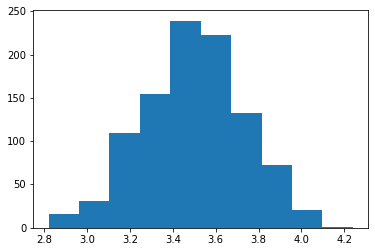

In [110]:
# demonstration of the central limit theorem
from numpy.random import seed
from numpy.random import randint
from numpy import mean
from matplotlib import pyplot
# seed the random number generator
seed(1)
# calculate the mean of 50 dice rolls 1000 times
means = [mean(randint(1, 7, 50)) for _ in range(1000)]
# plot the distribution of sample means
pyplot.hist(means)
pyplot.show()